In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        return self.model(x)

In [31]:
import struct

def load_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
        return images

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

train_images = load_images('input/train-images.idx3-ubyte')/255
train_labels = load_labels('input/train-labels.idx1-ubyte')
test_images = load_images('input/t10k-images.idx3-ubyte')/255
test_labels = load_labels('input/t10k-labels.idx1-ubyte')

flat_train_images = train_images.reshape(60000, 28*28)
flat_test_images = test_images.reshape(10000, 28*28)

y_train = train_labels
y_test = test_labels

X_train_tensor = torch.tensor(flat_train_images, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(flat_test_images, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [32]:
model = SimpleNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [33]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 0.2447
Epoch [2/10], Loss: 0.1064
Epoch [3/10], Loss: 0.0732
Epoch [4/10], Loss: 0.0564
Epoch [5/10], Loss: 0.0470
Epoch [6/10], Loss: 0.0395
Epoch [7/10], Loss: 0.0331
Epoch [8/10], Loss: 0.0270
Epoch [9/10], Loss: 0.0251
Epoch [10/10], Loss: 0.0201


In [35]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Train Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 97.32%
Train Accuracy: 98.99%


In [ ]:
# Test Accuracy: 97.86% with lr 0.003 and epochs 10

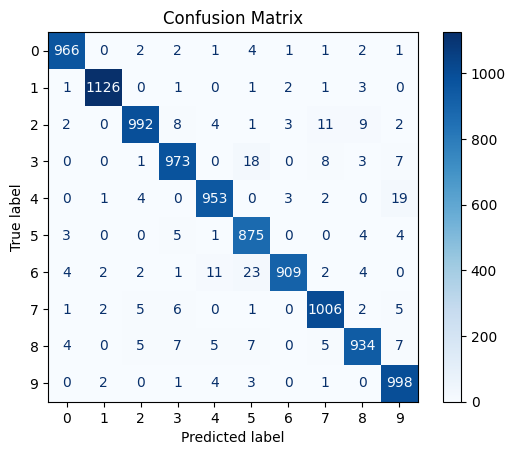

Accuracy:      0.9732
F1 Score:      0.9728
PR AUC (avg):  0.9959


In [34]:
def evaluate_model(model, dataloader, num_classes=10, device='cpu', show_confusion=True):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            _, predicted = torch.max(probs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # --- Accuracy ---
    accuracy = np.mean(all_preds == all_labels)

    # --- F1 Score (macro average) ---
    f1 = f1_score(all_labels, all_preds, average='macro')

    # --- PR-AUC (macro) ---
    y_true_bin = label_binarize(all_labels, classes=range(num_classes))  # shape: (N, num_classes)
    pr_auc_per_class = []

    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
        pr_auc = auc(recall, precision)
        pr_auc_per_class.append(pr_auc)

    pr_auc_macro = np.mean(pr_auc_per_class)

    # --- Confusion Matrix ---
    if show_confusion:
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
        disp.plot(cmap='Blues', values_format='d')
        plt.title("Confusion Matrix")
        plt.show()

    # --- Print Summary ---
    print(f"Accuracy:      {accuracy:.4f}")
    print(f"F1 Score:      {f1:.4f}")
    print(f"PR AUC (avg):  {pr_auc_macro:.4f}")

    return {
        'accuracy': accuracy,
        'f1': f1,
        'pr_auc_macro': pr_auc_macro,
        'pr_auc_per_class': pr_auc_per_class,
        'confusion_matrix': cm if show_confusion else None
    }

metrics = evaluate_model(model, test_loader, num_classes=10, device=device)